In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
alm = pd.read_csv('almanac_solves1.csv')
eph = pd.read_csv('ephemeris_solves1.csv')
general = pd.read_csv('general_data1.csv')
LLA = pd.read_csv('FK_coordinates_lla1.csv')
XYZ = pd.read_csv('FK_coordinates_xyz1.csv')

In [4]:
alm['TOW'] = alm.calc_stamp.apply(lambda st: int(st[:-1].split('.')[-1]))
eph['TOW'] = eph.calc_stamp.apply(lambda st: int(st[:-1].split('.')[-1]))
general['TOW'] = general.receiving_stamp.apply(lambda st: int(st[:-1].split('.')[-1]))
general[['X', 'Y', 'Z']] = general[['ecefX', 'ecefY', 'ecefZ']] 
LLA['TOW'] = LLA.receiving_stamp.apply(lambda st: int(st[:-1].split('.')[-1]))
XYZ['TOW'] = XYZ.receiving_stamp.apply(lambda st: int(st[:-1].split('.')[-1]))

alm['time'] = alm['TOW'] / 3600
eph['time'] = eph['TOW'] / 3600
general['time'] = general['TOW'] / 3600
LLA['time'] = LLA['TOW'] / 3600
XYZ['time'] = XYZ['TOW'] / 3600

# alm = alm.head(1e4)
# eph = eph.head(1e4)
# general = general.head(1e4)
# LLA = LLA.head(1e4)
# XYZ = XYZ.head(1e4)

In [5]:
# XYZ.normP_rec.head(100)

In [6]:
import pymap3d as pm
mylla = [55.690555555555555, 37.858333333333334, 140] # Дом
ECEF = pm.geodetic2ecef(*mylla)
H_ = 2000
MS = 3
normP_dead = 0.001070452

In [7]:
def draw_filtered(DF, H, name, base):
    DF = DF[(DF.normP_rec > normP_dead) & (DF.normP_alm > normP_dead) & (DF.normP_eph > normP_dead)]
    
    fig, axs = plt.subplots(3, figsize=(14, 8))
    type_names = 'XYZ' if name == 'XYZ' else ['lat', 'lon', 'alt']
    meas_type = [', km', ', km', ', km'] if name == 'XYZ' else [', deg', ', deg', ', m']
    scale = 1e-3 if name == 'XYZ' else 1
    for i, type in enumerate(type_names):
        for source in ['eph', 'alm', 'rec']:
            # print(f'{type}_{source}')
            # axs[i].plot(DF.time, DF[f'{type}_{source}'] * scale, label=source)
            axs[i].scatter(DF.time, DF[f'{type}_{source}'] * scale, label=source, s=MS)
        axs[i].plot([min(DF.time), max(DF.time)], [base[i] * scale, base[i] * scale], '--', label='real', color='red')
        axs[i].set_ylabel(type + meas_type[i])
        axs[i].set_ylim((base[i] - H[i]) * scale, (base[i] + H[i]) * scale)
        axs[i].legend(loc='upper right')
        axs[i].grid()
    axs[0].set_title(f'Отфильтрованные коодинаты ({name}, ±{H_} m)')
    axs[-1].set_xlabel('TOW, h')
    plt.savefig(f'{name}_filtered{H_}.png', dpi=600)
    # plt.show()       
      

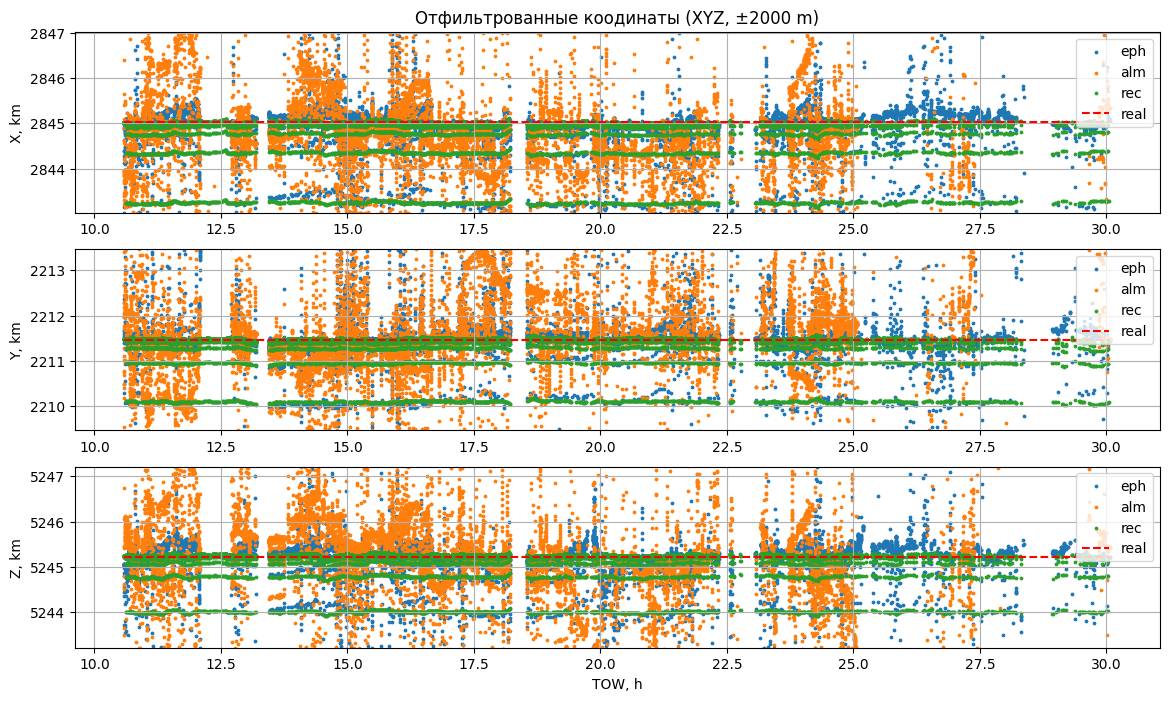

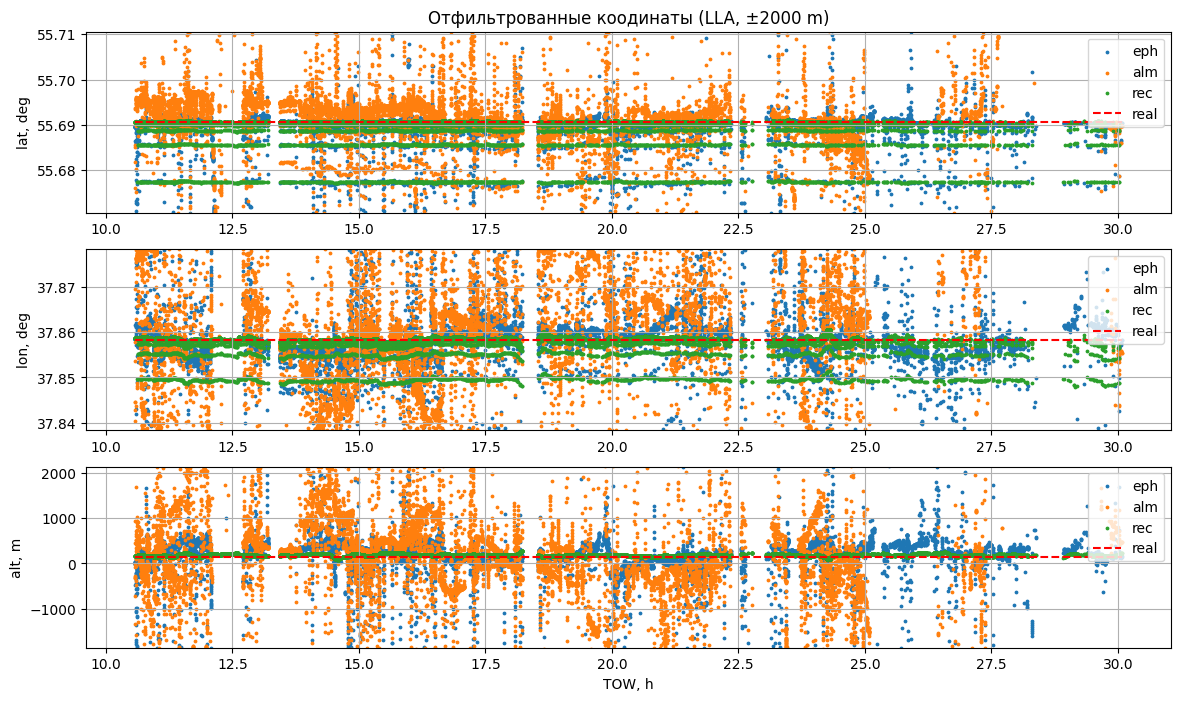

In [8]:
draw_filtered(XYZ, [H_, H_, H_], 'XYZ', ECEF)
draw_filtered(LLA, [H_ / 100e3, H_ / 100e3, H_ / 1], 'LLA', mylla)

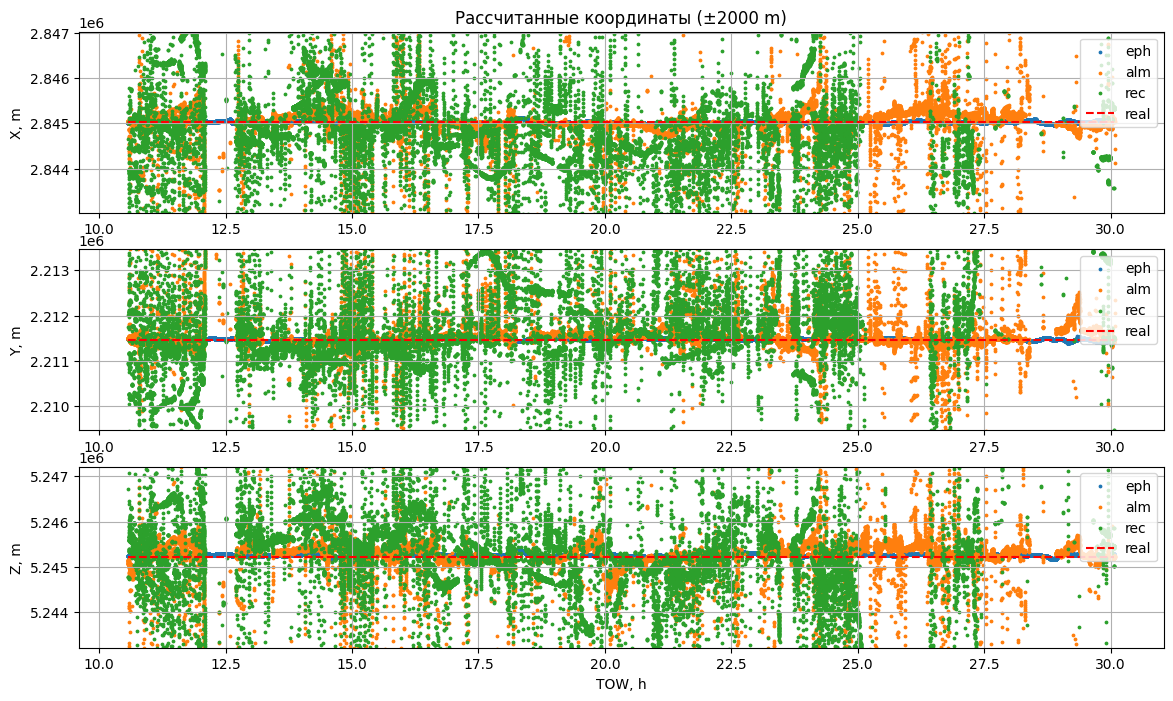

In [9]:
fig, axs = plt.subplots(3, figsize=(14, 8))
for i, type in enumerate('XYZ'):
    for name, DF in zip(['eph', 'alm', 'rec'], [general, eph, alm]):
        axs[i].scatter(DF.time, DF[type], label=name, s=MS)
        # axs[i].plot(DF.time, DF[type], label=name)
    axs[i].plot([min(DF.time), max(DF.time)], [ECEF[i], ECEF[i]], '--', label='real', color='red')
    axs[i].set_ylabel(type + ', m')
    axs[i].set_ylim(ECEF[i] - H_, ECEF[i] + H_)
    axs[i].legend(loc='upper right')
    axs[i].grid()
axs[0].set_title(f'Рассчитанные координаты (±{H_} m)')
axs[-1].set_xlabel('TOW, h')
plt.savefig(f'calculated_xyz{H_}.png', dpi=600)
# plt.show()

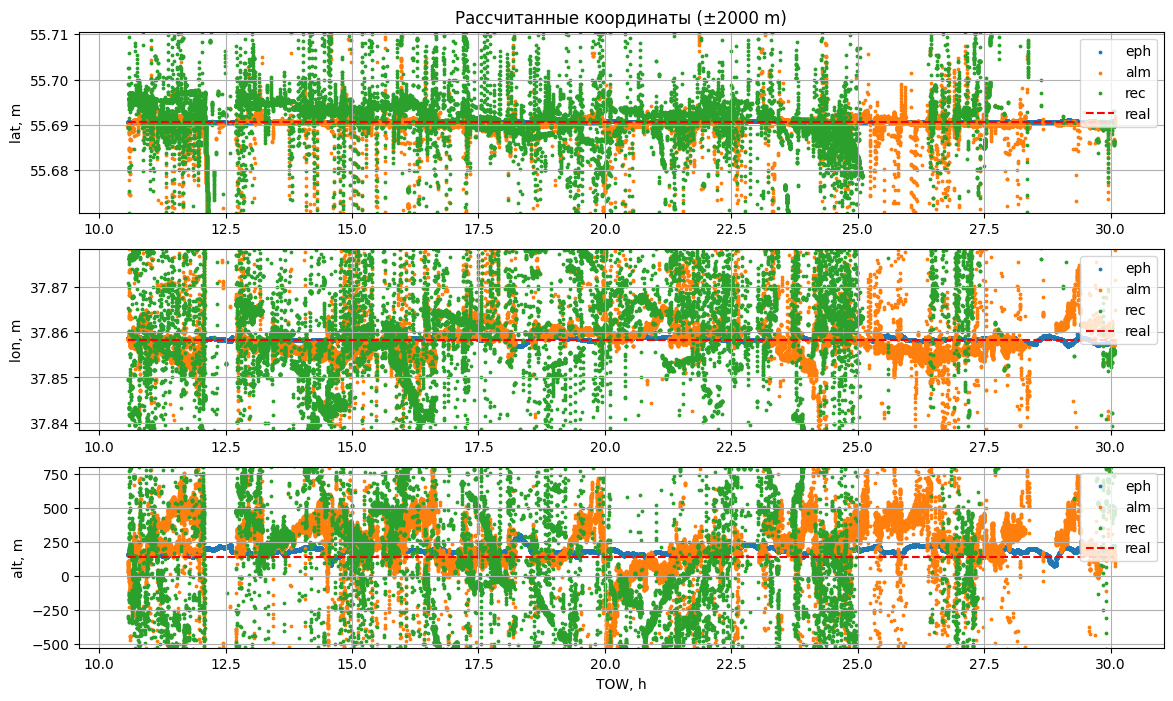

In [10]:
fig, axs = plt.subplots(3, figsize=(14, 8))
import Transformations
for df in [general, eph, alm]:
    df['lla'] = df.apply(lambda row: Transformations.ecef2lla(row.X, row.Y, row.Z), axis=1)
    df['lat'] = df.lla.apply(lambda lla: lla[0])
    df['lon'] = df.lla.apply(lambda lla: lla[1])
    df['alt'] = df.lla.apply(lambda lla: lla[2])
H = [H_ / 100e3, H_ / 100e3, H_ / 3]
for i, type in enumerate(['lat', 'lon', 'alt']):
    for name, DF in zip(['eph', 'alm', 'rec'], [general, eph, alm]):
        axs[i].scatter(DF.time, DF[type], label=name, s=MS)
        # axs[i].plot(DF.time, DF[type], label=name)
    axs[i].plot([min(DF.time), max(DF.time)], [mylla[i], mylla[i]], '--', label='real', color='red')
    axs[i].set_ylabel(type + ', m')
    axs[i].set_ylim(mylla[i] - H[i], mylla[i] + H[i])
    axs[i].legend(loc='upper right')
    axs[i].grid()
axs[0].set_title(f'Рассчитанные координаты (±{H_} m)')
axs[-1].set_xlabel('TOW, h')
plt.savefig(f'calculated_lla{H_}.png', dpi=600)


In [11]:
#TODO: график- количество спутников (АЕ), ошибка (RAE), ???
H_ = 2000

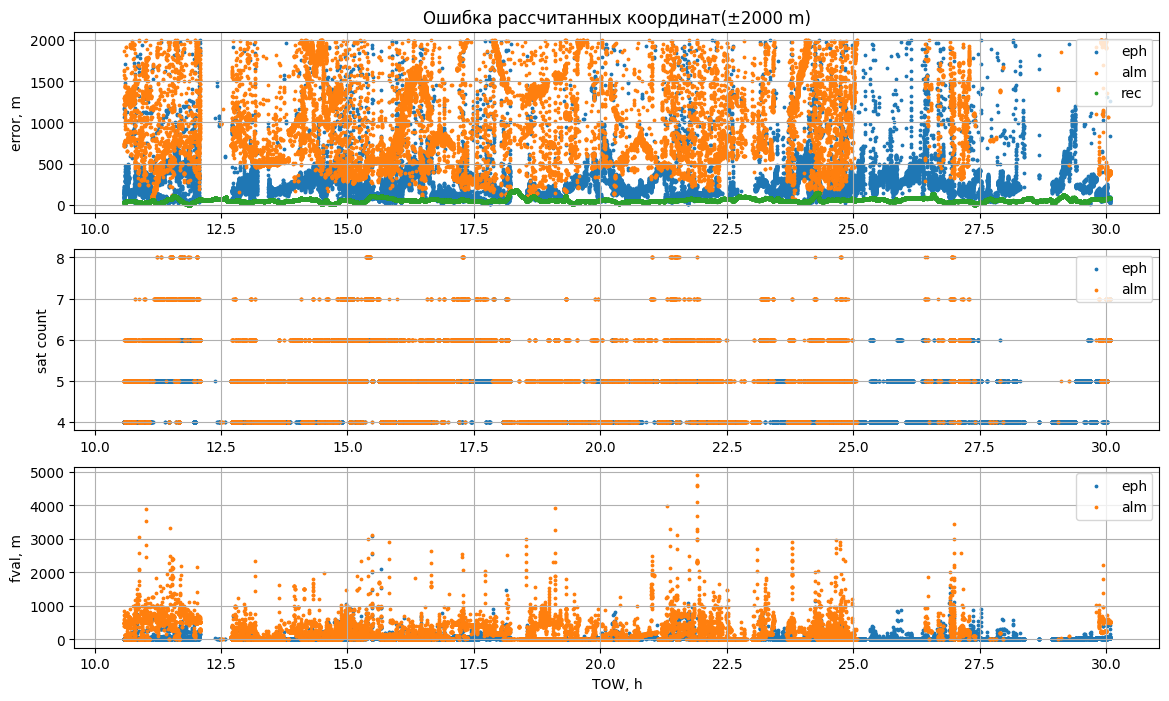

In [12]:
fig, axs = plt.subplots(3, figsize=(14, 8))
for name, DF in zip(['eph', 'alm', 'rec'], [eph, alm, general ]):
    DF['error'] = DF.apply(lambda row: np.linalg.norm([row.X-ECEF[0], row.Y-ECEF[1], row.Z-ECEF[2]]) , axis=1)
    DF = DF[DF.error < H_]
    axs[0].scatter(DF.time, DF['error'], label=name, s=MS)
    if name != 'rec':
        axs[1].scatter(DF.time, DF['sat_count'], label=name, s=MS)
        axs[2].scatter(DF.time, DF['fval'], label=name, s=MS)
    # axs[i].plot(DF.time, DF[type], label=name)
axs[0].set_ylabel('error, m')
axs[1].set_ylabel('sat count')
axs[2].set_ylabel('fval, m')
for i in range(3):
    axs[i].legend(loc='upper right')
    axs[i].grid()
axs[0].set_title(f'Ошибка рассчитанных координат(±{H_} m)')
axs[-1].set_xlabel('TOW, h')
plt.savefig(f'error_and_satcount.png', dpi=600)

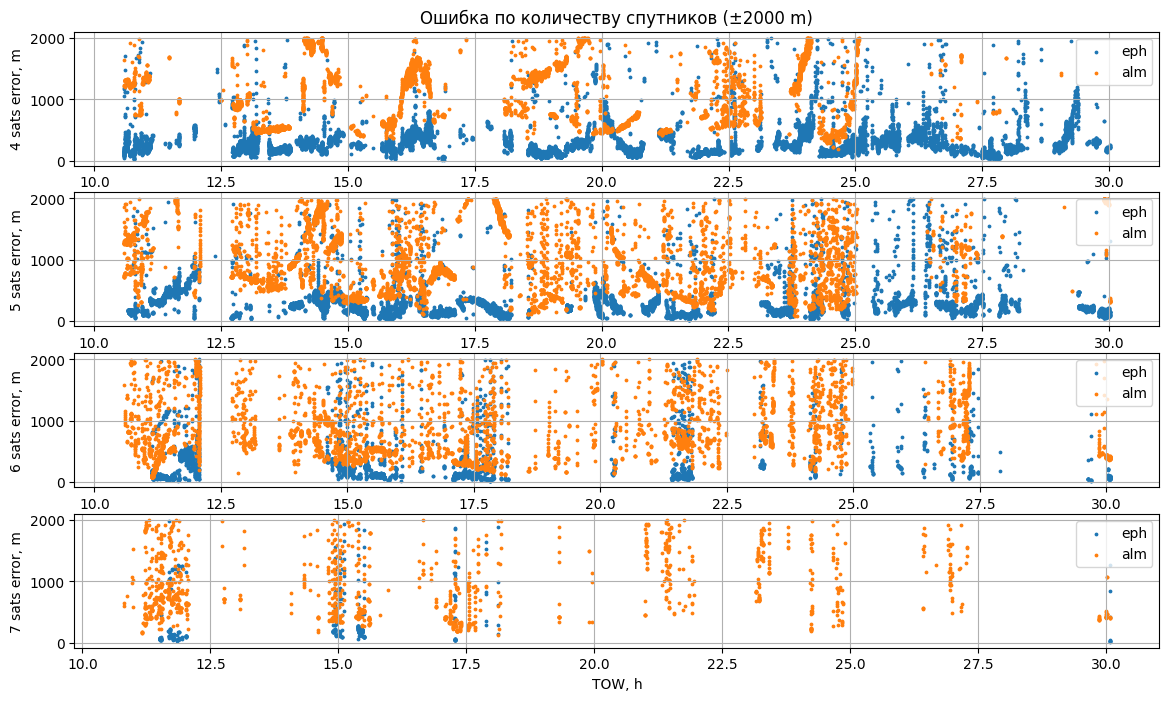

In [13]:
fig, axs = plt.subplots(4, figsize=(14, 8))

for name, DF in zip(['eph', 'alm'], [ eph, alm]):
    DF['error'] = DF.apply(lambda row: np.linalg.norm([row.X-ECEF[0], row.Y-ECEF[1], row.Z-ECEF[2]]) , axis=1)
    for i, sat_count in enumerate([4, 5, 6, 7]):
        DF1 = DF[(DF.error < H_) & (DF.sat_count == sat_count)]
        axs[i].scatter(DF1.time, DF1['error'], label=name, s=MS)
        axs[i].set_ylabel(f'{sat_count} sats error, m')
        # if name != 'rec':
        #     axs[1].scatter(DF.time, DF['sat_count'], label=name, s=MS)
        # axs[i].plot(DF.time, DF[type], label=name)
for i in range(4):
    axs[i].legend(loc='upper right')
    axs[i].grid()
axs[0].set_title(f'Ошибка по количеству спутников (±{H_} m)')
axs[-1].set_xlabel('TOW, h')
plt.savefig(f'errorFORsatcount.png', dpi=600)